In [9]:
N = 6   # can be changed accordingly to the desired number of states

T = 20  # time periods is kept to be 20 for all our analysis

rho = 0.8 # can be changed accordingly

In [10]:
# data generation code

import numpy as np
import pandas as pd

def generate_staggered_law_ar1_data(N, T, rho, num_individuals, mean=0, std_dev=1):
    
    white_noise = np.random.normal(mean, std_dev, size=(N, num_individuals, T)) # generatingk random white noise for each individual

    data = np.zeros((N, num_individuals, T))  # Initializing the array to store the data

    # Including state and time effects 

    alphas = np.random.normal(0,1, size=N)
    betas = np.random.normal(0,1, size = T)

    # Generating the AR(1) process data for each individual

    for i in range(N):
        alpha = alphas[i]
        for j in range(num_individuals):
            for t in range(T):
                beta = betas[t]
                if t == 0:
                    data[i, j, t] = alpha + beta + white_noise[i, j, t]
                else:
                    data[i, j, t] = alpha + beta + rho * data[i, j, t - 1] + white_noise[i, j, t]

    
    reshaped_data = data.reshape((N * num_individuals, T))  # Reshaping the data array for easier DataFrame creation

 
    df = pd.DataFrame(reshaped_data, columns=[f'{t}' for t in range(T)])    # Creating a DataFrame with column names as time periods

    
    df['state'] = np.repeat(np.arange(1, N + 1), num_individuals)  # Add a new 'state' column with repeated state values

    
    df['individual'] = np.tile(np.arange(1, num_individuals + 1), N)  # Add a new 'individual' column with repeated individual values


    melted_df = pd.melt(df, id_vars=['state', 'individual'], var_name='time', value_name= 'value') # to take the data in the long format

   
    melted_df['time'] = melted_df['time'].astype(int)   # Converting the 'time' column to int


    data = melted_df.copy()

    data['time'] = data['time'].astype(int)

   
    return data

In [11]:
def calculate_standard_error(t_statistic, parameter_estimate):
    """
    Calculate the standard error given a t-statistic and the parameter estimate.
    
    Parameters:
    t_statistic (float): The t-statistic value.
    parameter_estimate (float): The estimated parameter value (e.g., mean difference).
    
    Returns:
    float: The calculated standard error.
    """
    if t_statistic == 0:
        raise ValueError("t_statistic cannot be zero.")
    return abs(parameter_estimate / t_statistic)



Number of times null hypothesis is rejected: 61 out of 1000 simulations
Type 1 Error: 0.061
Bias for Coefficient of Treatment : 0.012982348835658596
MSE for Coefficient of Treatment : 2.278826804035141
RMSE for Coefficient of Treatment : 1.5095783530625833
Average Standard Error: 1.4897019500731699
Standard Error of the beta_1 distribution: 1.5095225280378728
The confidence interval is (-2.945681806118572, {2.971646503789889})


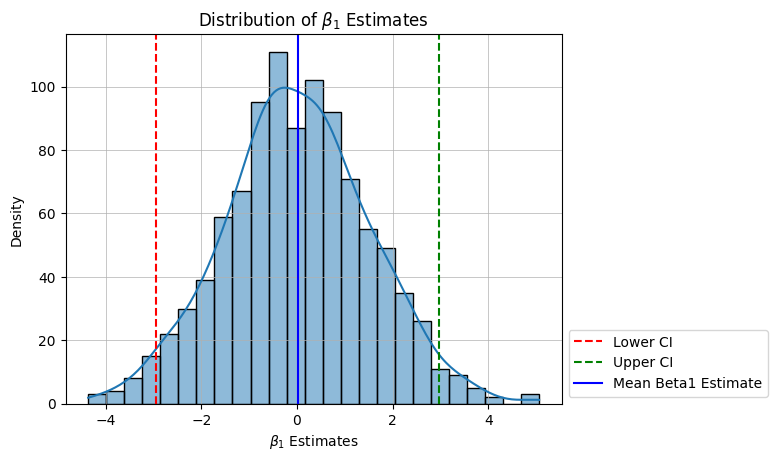

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smp
from wildboottest.wildboottest import wildboottest
import warnings


alpha = 0.05  # Significance level
num_simulations = 1000
num_individuals = 1

reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []

np.random.seed(42) # setting seed for reproducibility


for _ in range(num_simulations):

    data = generate_staggered_law_ar1_data( N, T, rho, num_individuals) # this time the data generation is inside the loop to ensure everytime new data is generated

    states = data['state'].unique()
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)   # To give the treatment to exactly half the states in a staggered approach

    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)  # Assigning treatment year to each treatment state, staggered between 5 and 15th time period

    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame
    
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)
    
    
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)  # Create state dummy variables

    state_dummies = state_dummies.astype(int)

    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True) # Create time dummy variables

    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)

    columns_to_exclude = ['state', 'value', 'individual', 'time']

    X_columns = [col for col in data.columns if col not in columns_to_exclude]

    warnings.filterwarnings("ignore")

    formula = "value ~ "
    
    formula += " + ".join(X_columns)

    model = smp.ols(formula = formula , data = data)

    result = model.fit()

    wildboottest_results = wildboottest(model, param="TREATMENT", cluster=data['state'], B= 400, bootstrap_type='11', show = False)
    wildboottest_results = pd.DataFrame(wildboottest_results)
    p_value = wildboottest_results['p-value'].iloc[0]
    param = result.params['TREATMENT']
    t_stat = wildboottest_results['statistic'].iloc[0] 

    
    # Checking  if null hypothesis for beta1 is rejected

    if p_value < alpha:
        reject_count += 1

    beta1_estimates.append(param)
    
    bias = np.mean(beta1_estimates) - true_beta1_value

    squared_error = (param - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    # Extracting the standard error of the 'TREATMENT' coefficient 

    standard_error = calculate_standard_error(t_stat, param)
    standard_error_values.append(standard_error)


type1_error = reject_count/ num_simulations
bias = np.mean(bias)
mse = np.mean(squared_error_values)
rmse = np.sqrt(mse)
average_standard_error = np.mean(standard_error_values)


std_error_beta_distribution = np.std(beta1_estimates)  # Calculating the standard error of the distribution of beta

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.histplot(beta1_estimates, kde = True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()

